In [1]:
%pylab inline
from tempfile import NamedTemporaryFile
import pywren
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
from drawnow import drawnow
import time
import pylab as pl
%matplotlib inline

from numpy import nan, inf

Populating the interactive namespace from numpy and matplotlib


15625


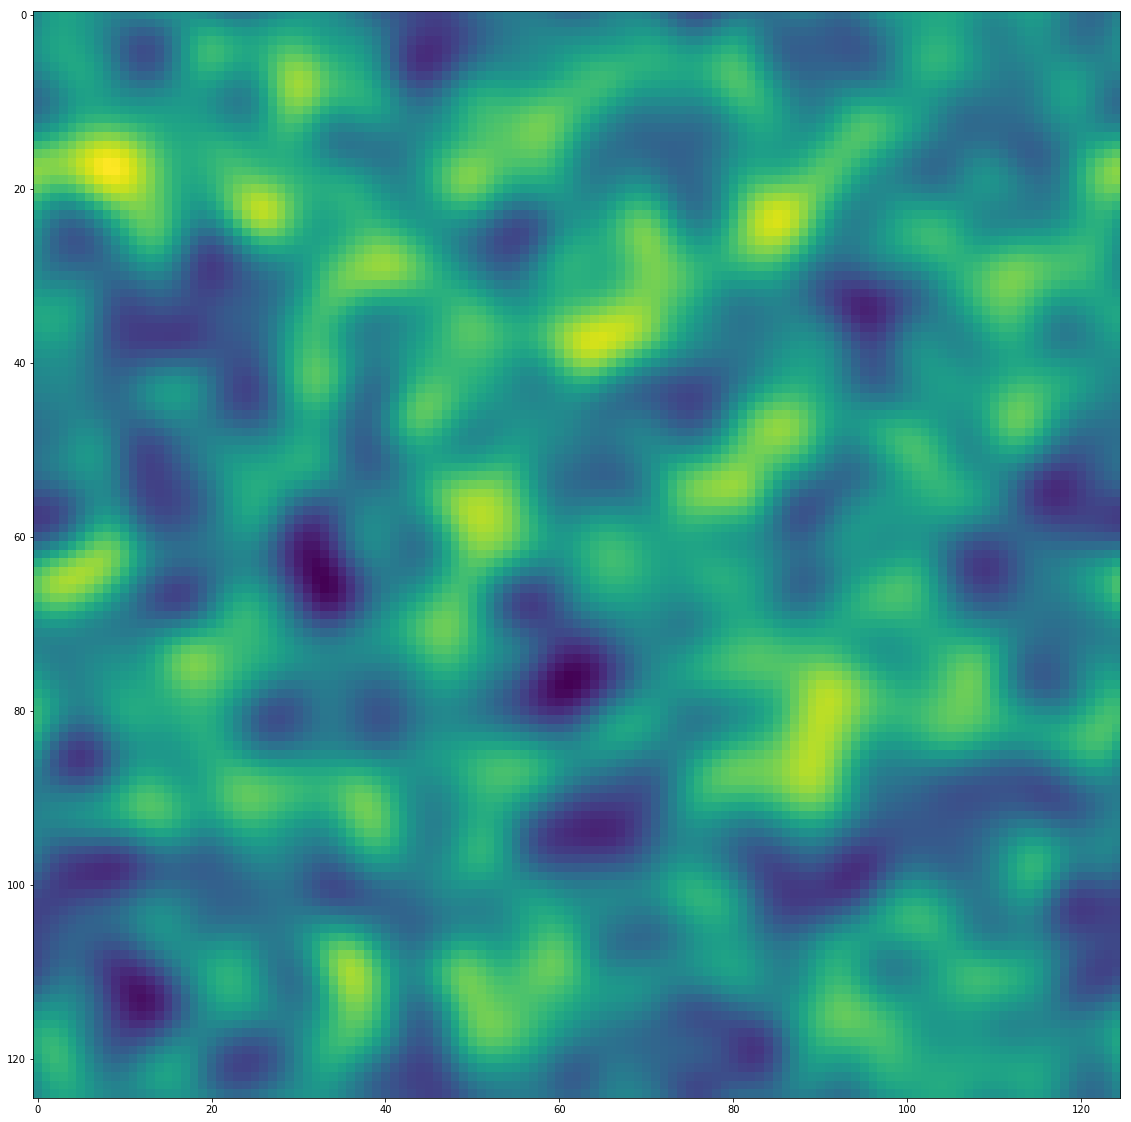

In [33]:
def make_diffuser_surface(M, sigma):
    #M = 1025;
    #sigma = .02;

    seeds = np.random.rand(M,M)
    seeds_ft = np.fft.fft2(seeds)
    fx = np.linspace(-1,1,M)

    filt_f = np.exp(-.5*np.square(fx/sigma))
    filt_n = filt_f/np.sum(filt_f)
    filt_2d = np.fft.ifftshift(np.outer(filt_n,filt_n))
    surf_out = np.fft.ifft2(filt_2d*seeds_ft)
    s = np.shape(filt_2d)
    return surf_out

diffuser_surface = .5*make_diffuser_surface(125,.1)

fig1 = plt.imshow(np.real(diffuser_surface), interpolation="nearest",
    vmin=np.min(np.min(np.abs(diffuser_surface))),
    vmax=np.max(np.max(np.abs(diffuser_surface))))
fig = plt.gcf()
fig.set_size_inches(20,20)
print(diffuser_surface.size)

In [197]:
def propagate_field(lam, ps, z, U):
    k = 2*np.pi/lam   
    siz = np.shape(U)
    fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
    fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
    x = np.linspace(-siz[1]/2*ps,siz[1]/2*ps,siz[1])
    y = np.linspace(-siz[0]/2*ps,siz[0]/2*ps,siz[0])
    X,Y = np.meshgrid(x,y)
    Fx,Fy = np.meshgrid(fx,fy)
    Uf = np.fft.fftshift(np.fft.fft2(U))
    Hf = np.exp(1j*2*np.pi*z/lam * np.sqrt(1-(lam*Fx)**2 - (lam*Fy)**2))
    Up = np.fft.ifft2(np.fft.ifftshift(Uf*Hf))
    return Up

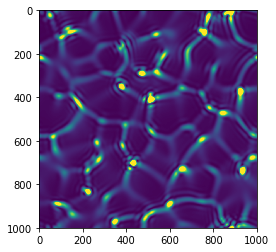

In [206]:
def propagate_wrapper(z):
    lam = 532e-9
    ps = .5e-6
    def make_diffuser_surface(M, sigma):
        random.seed(1)
        seeds = np.random.rand(M,M)
        seeds_ft = np.fft.fft2(seeds)
        fx = np.linspace(-1,1,M)

        filt_f = np.exp(-.5*np.square(fx/sigma))
        filt_n = filt_f/np.sum(filt_f)
        filt_2d = np.fft.ifftshift(np.outer(filt_n,filt_n))
        surf_out = np.fft.ifft2(filt_2d*seeds_ft)
        s = np.shape(filt_2d)
        return surf_out
    k = 2*np.pi/lam
    diffuser_surface = .5*make_diffuser_surface(1000,.01)
    U = np.exp(1j*k*diffuser_surface*1e-2*3)
    Up = propagate_field(lam, ps, z, U)
    return Up

Up = propagate_wrapper(1000e-6)
Ip = np.abs(Up)**2
plt.close(fig)
plt.imshow(Ip,vmin=0,vmax=np.percentile(Ip,99))

fig = plt.gcf()
#fig.set_size_inches(20,20)

plt.show()

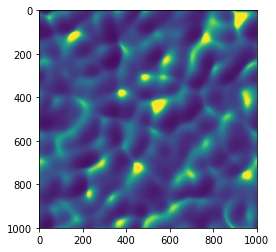

In [207]:
wrenexec = pywren.default_executor()

future = wrenexec.call_async(propagate_wrapper, 200e-6)

Up = future.result()
Ip = np.abs(Up)**2
plt.close(fig)
plt.imshow(Ip,vmin=0,vmax=np.percentile(Ip,99))

fig = plt.gcf()


plt.show()

In [ ]:
start = time.time()
zvec = np.linspace(1e-6,5000e-6,200)
futures = wrenexec.map(propagate_wrapper, zvec)
Up_list = pywren.get_all_results(futures)
end = time.time()
N = np.shape(Up_list)

c = -1;
start_cpu = time.time()
for z in zvec:
    c = c+1
    if c==1: Up_list_cpu = propagate_wrapper(z)
    else:Up_list_cpu = np.append(Up_list_cpu,propagate_wrapper(z))
    
end_cpu = time.time()
print("Pywren total time for",N[0],"planes:",end-start)
print("CPU total time for ",N[0],"planes:",end_cpu-start_cpu)
print(shape(Up_list))
print(shape(Up_list_cpu))

KeyboardInterrupt: 

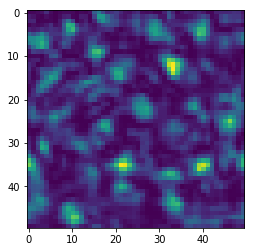

In [124]:
import time
import pylab as pl
from IPython import display
for Up in Up_list:
    Ip = np.abs(Up)**2
    pl.imshow(Ip)
    fig = plt.gcf()
    #fig.set_size_inches(20,20)
    display.clear_output(wait=True)
    display.display(fig)
    #time.sleep(1/1000)
    
plt.clf()